# RO1
1. Examining factors that influence working over the required working hours and under the required working hours.
2. Conducting association rule analysis to identify factors influencing the mismatch between highest qualifications and employment qualifications.
3. Investigating how individuals address the skill gap when they lack the necessary qualifications in their current profession

In [1]:
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Data

In [20]:
df = pd.read_csv('data_sorted.csv')
codebook = pd.read_excel('PIAAC\Cycle 1\International Codebook_PIAAC Public-use File (PUF) Variables and Values.xlsx')

print(df.shape)
df.head()

C:\Users\Anis\AppData\Local\Temp\ipykernel_6428\2046365629.py:1: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data_sorted.csv')


(11470, 93)


,Skill use work - ICT - Computer - How often - Programming language,ISCO1C,Skill use work - ICT - Computer - How often - Real-time discussions,Skill use work - How often - Organising own time,Skill use everyday life - ICT - Computer - How often - Word,Skill use work - How often - Planning others activities,PVPSL6,About yourself - Learning strategies - Attribute something new,ICTHOME,PVPSL8,...,Education - Highest qualification - Level,PVPSL4,PVPSL10,Skill use everyday life - ICT - Internet - How often - In order to better understand various issues,About yourself - Learning strategies - Get to the bottom of difficult things,WorkHours,WorkHours_Difference,Qualification_Comparision,Qualification_Status,PVPSL_Performance
0,At least once a week but not every day,Service workers and shop and market sales workers,Less than once a month,Every day,Less than once a week but at least once a month,Never,315.18911,To a high extent,2.021940,296.26412,...,"ISCED 5A, bachelor degree",342.29315,318.98045,Less than once a week but at least once a month,To a high extent,Over Average,18,Over by 5 level(s),Over,Moderate performer
1,Less than once a week but at least once a month,Professionals,Never,Every day,Never,Less than once a month,326.64999,To some extent,1.646234,273.53912,...,"ISCED 5A, bachelor degree",325.28718,296.98809,At least once a week but not every day,To a high extent,Over Average,8,Equal,Equal,Moderate performer
2,Never,"Legislators, senior officials and managers",At least once a week but not every day,Every day,At least once a week but not every day,At least once a week but not every day,285.41693,To some extent,3.430657,279.23163,...,"ISCED 5A, bachelor degree",316.26258,249.59748,Every day,Very little,Over Average,18,Under by 2 level(s),Under,Weak performer
3,Never,Service workers and shop and market sales workers,Never,Less than once a month,Less than once a month,Never,332.55340,To a high extent,1.623673,284.82134,...,ISCED 5B,318.41257,325.03424,At least once a week but not every day,To some extent,Under Average,-15,Over by 5 level(s),Over,Moderate performer
4,Never,Technicians and associate professionals,Never,Never,Never,Never,300.41854,To some extent,1.365424,290.70099,...,ISCED 3C 2 years or more,307.69612,307.37447,Less than once a month,Very little,Under Average,-10,Over by 1 level(s),Over,Moderate performer


In [21]:
# variables

# dropped AGE_R, ISCO2C
demographic_var = ['CNTRYID', 'AGE_R', 'GENDER_R', 'LNG_HOME', 'NATIVELANG', 'NATIVESPEAKER', 'J_Q06b', 'J_Q07b', 'I_Q08', 'J_Q04a']
eduwork_var = ['CNTRYID', 'C_Q07', 'C_D06', 'B_Q01a', 'B_Q01a3', 'B_Q01b', 'D_Q12a', 'B_Q05c', 'B_Q10c', 'D_Q14', 'ISCOSKIL4', 'ISCO1C', 'D_Q10', 'D_Q03', 'D_Q04', 'D_Q07a', 'D_Q07b', 'D_Q08a', 'D_Q08b', 'VET', 'NFEHRS']

worksl_var = ['CNTRYID', 'ICTWORK', 'NFEHRSJR']
worksl_var.extend(codebook.loc[codebook['Name'].str.startswith('F_'), 'Name'].tolist())
worksl_var.extend(codebook.loc[codebook['Name'].str.startswith('G_') & codebook['Label'].str.contains('ICT'), 'Name'].tolist())

lifesl_var = ['CNTRYID', 'ICTHOME', 'NFEHRSNJR']
lifesl_var.extend(codebook.loc[codebook['Name'].str.startswith('H_') & codebook['Label'].str.contains('ICT'), 'Name'].tolist())
lifesl_var.extend(codebook.loc[codebook['Name'].str.startswith('I_') & codebook['Label'].str.contains('Learning'), 'Name'].tolist())

pvpsl = []
pvpsl.extend(codebook.loc[codebook['Name'].str.startswith('PVPSL'), 'Name'].tolist())


vars = list(set(demographic_var + eduwork_var + worksl_var + lifesl_var + pvpsl))
vars_keep = [var for var in vars if not (var[0].isalpha() and var[1] == '_')]
vars_change = [var for var in vars if var[0].isalpha() and var[1] == '_']

vars_dict = {}

for i in vars_change:
    match = codebook.loc[codebook['Name'] == i, 'Label'].tolist()
    if match:
        vars_dict[i] = match[0]


demographic_mapped = [vars_dict.get(value, value) if value is not None else None for value in demographic_var]
eduwork_mapped = [vars_dict.get(value, value) if value is not None else None for value in eduwork_var]
worksl_mapped = [vars_dict.get(value, value) if value is not None else None for value in worksl_var]
lifesl_mapped = [vars_dict.get(value, value) if value is not None else None for value in lifesl_var]

hours_var = ['WorkHours', 'WorkHours_Difference']
match_var = ['Qualification_Comparision', 'Qualification_Status']
performance_var = 'PVPSL_Performance'

print(len(demographic_mapped) + len(eduwork_mapped) + len(worksl_mapped) + len(lifesl_mapped) + len(hours_var) + len(match_var) + len(performance_var))

101


# Data Setup

In [22]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score

In [23]:
sns.set_palette("dark")
sns.set_style('darkgrid')
sns.set(font_scale=1.1)

In [24]:
countries = df['CNTRYID'].unique()
# 'NFEHRS', 'NFEHRSJR', 'NFEHRSNJR'
drop = ['AGE_R', 'ISCO2C', 'WorkHours_Difference', 'Current work - Hours/week'] + pvpsl
df2 = df.drop(columns=drop).copy()

In [25]:
target = ['WorkHours']
df3 = df2[df2['WorkHours'] != 'Average']

X = df3.drop(columns=target)
y = df3[target]
feature_names = X.columns

class_labels = df3['WorkHours'].unique().tolist()

In [26]:
print(df.shape) # raw
print(df2.shape) # after fs
print(df3.shape) # only above/below average

df3[target].value_counts()

(11470, 93)
(11470, 79)
(6597, 79)


WorkHours    
Under Average    3347
Over Average     3250
Name: count, dtype: int64

In [27]:
folder_path = 'RQ1_CVV/'

In [28]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
imputer = SimpleImputer(strategy='most_frequent')

cat = X.select_dtypes(include = 'object').columns

In [29]:
report_items = ['precision', 'recall', 'f1-score', 'support']

# evaluation function
def getEvaluationMetrics(y_test, y_pred, y_proba):
    evals = []
    evals_score = [] # for tables
    
    # accuracy score
    score = accuracy_score(y_test, y_pred)
    evals.append(score)
    evals_score.append(score)
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    evals.append(cm)
    
    # classification report
    report = classification_report(y_test, y_pred, target_names=class_labels)
    evals.append(report)
    
    report_dict = classification_report(y_test, y_pred, target_names=class_labels, output_dict=True)
    for i in class_labels:
        for item in report_items:
            evals_score.append(report_dict[i][item])
    
    # roc auc
    auc = roc_auc_score(y_test, y_proba)
    evals.append(auc)
    evals_score.append(auc)
    
    return evals, evals_score

In [30]:
def showEvaluationMetrics(evals, text=''):
    acc = 'Accuracy score'
    cm =  'Confusion matrix'
    rep = 'Classification report'
    roc = 'AUC ROC score'
    
    if text != '':
        acc = acc + ' for ' + text
        cm = cm + ' for ' + text
        rep = rep + ' for ' + text
        roc = roc + ' for ' + text

        print(acc, ' : ', evals[0])
        
        sns.heatmap(evals[1], annot=True, fmt='g', 
                xticklabels=class_labels,
                yticklabels=class_labels,)
        plt.xlabel('Prediction')
        plt.ylabel('Actual')
        plt.title(cm)
        plt.show()
        
        print(rep, ' : ')
        print(evals[2])
        
        print(roc, ':', evals[3])
    else:
        print(acc, ' : ', evals[0])
        
        sns.heatmap(evals[1], annot=True, fmt='g', 
                xticklabels=class_labels,
                yticklabels=class_labels,)
        plt.xlabel('Prediction')
        plt.ylabel('Actual')
        plt.title(cm)
        plt.show()
        
        print(rep, ' : ')
        print(evals[2])
        
        print(roc, ':', evals[3])

In [31]:
folds = [i for i in range(2, 11)] # 2-10 folds

# encoding
X_encoded = X.copy()

X_encoded[cat] = enc.fit_transform(X_encoded[cat])        
X_encoded[cat] = imputer.fit_transform(X_encoded[cat])

y_encoded = y.values.ravel()

X_enc, y_enc = shuffle(X_encoded, y_encoded, random_state=5)

def crossValidate(model, fold):
    cv_res = cross_validate(model, X_enc, y_enc, cv=fold, return_train_score=False)
    
    mean = cv_res['test_score'].mean()
    
    print('Fold: ', fold)
    # print(cv_res.keys())
    print('Scores: ', cv_res['test_score'], '-'*25, 'Mean score: ', mean)
    print()
    
    return mean

In [32]:
def crossValidate_pred(model, fold):
    cv_res = cross_validate(model, X_enc, y_enc, cv=fold, return_estimator =True)
    
    y_pred = cross_val_predict(model, X_enc, y_enc, cv=fold)
    y_proba = cross_val_predict(model, X_enc, y_enc, cv=fold, method='predict_proba')[:, 1]
    
    return cv_res, y_pred, y_proba

In [33]:
def get_importance(cv_res, criterion):
    features = []
    col_cri = 'Features_' + str(criterion)
    col_imp = 'Importance_' + str(criterion)
    
    for estimator in cv_res['estimator']:
        features_df = pd.DataFrame({col_cri: feature_names,
                                    col_imp: estimator.feature_importances_,}).sort_values(by=col_cri).reset_index(drop=True)
        # sort for consistency
        features.append(features_df[col_imp].values)
    
    mean_features = np.mean(features, axis=0)
    
    mean_features_df = pd.DataFrame({col_cri: feature_names,
                                    col_imp: mean_features}).sort_values(by=col_imp, ascending=False).reset_index(drop=True)
    
    return mean_features_df

## Random Forest Classifier

### Best Accuracy

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
n_vals = [i for i in range(5, 105, 5)]
criterions = ['gini', 'entropy', 'log_loss']

scores_dict = {}

for cri in criterions:
    scores_dict[cri] = {}
    
    for fold in folds:
        scores_dict[cri][fold] = []
        index = folds.index(fold)
        
        scores = []

        for n in n_vals:
            rf = RandomForestClassifier(n_estimators=n, criterion=cri, random_state=5)
            score = crossValidate(rf, fold)
            scores_dict[cri][fold].append(score)

Fold:  2
Scores:  [0.67474992 0.70133414] ------------------------- Mean score:  0.6880420330618224

Fold:  2
Scores:  [0.69505911 0.72346877] ------------------------- Mean score:  0.709263938885867

Fold:  2
Scores:  [0.71082146 0.74226804] ------------------------- Mean score:  0.726544751142958

Fold:  2
Scores:  [0.71264019 0.7543966 ] ------------------------- Mean score:  0.7335183990003035

Fold:  2
Scores:  [0.719612   0.75530625] ------------------------- Mean score:  0.7374591249236451

Fold:  2
Scores:  [0.72052137 0.7565191 ] ------------------------- Mean score:  0.7385202362992553

Fold:  2
Scores:  [0.72658381 0.7543966 ] ------------------------- Mean score:  0.7404902086395881

Fold:  2
Scores:  [0.72446196 0.75803517] ------------------------- Mean score:  0.7412485655005807

Fold:  2
Scores:  [0.73204001 0.75894482] ------------------------- Mean score:  0.7454924135821521

Fold:  2
Scores:  [0.73113065 0.76046089] ------------------------- Mean score:  0.7457957655

Current criterion:  gini
Fold :  2  - Highest scoring:  0.7506458579156703  at n_val =  70
Fold :  3  - Highest scoring:  0.7530695770804913  at n_val =  80
Fold :  4  - Highest scoring:  0.7595900178253119  at n_val =  90
Fold :  5  - Highest scoring:  0.7556504009005904  at n_val =  95
Fold :  6  - Highest scoring:  0.7559544489480795  at n_val =  100
Fold :  7  - Highest scoring:  0.7600447207542061  at n_val =  100
Fold :  8  - Highest scoring:  0.7571658943807003  at n_val =  80
Fold :  9  - Highest scoring:  0.7554949219342125  at n_val =  100
Fold :  10  - Highest scoring:  0.7558021796109808  at n_val =  80


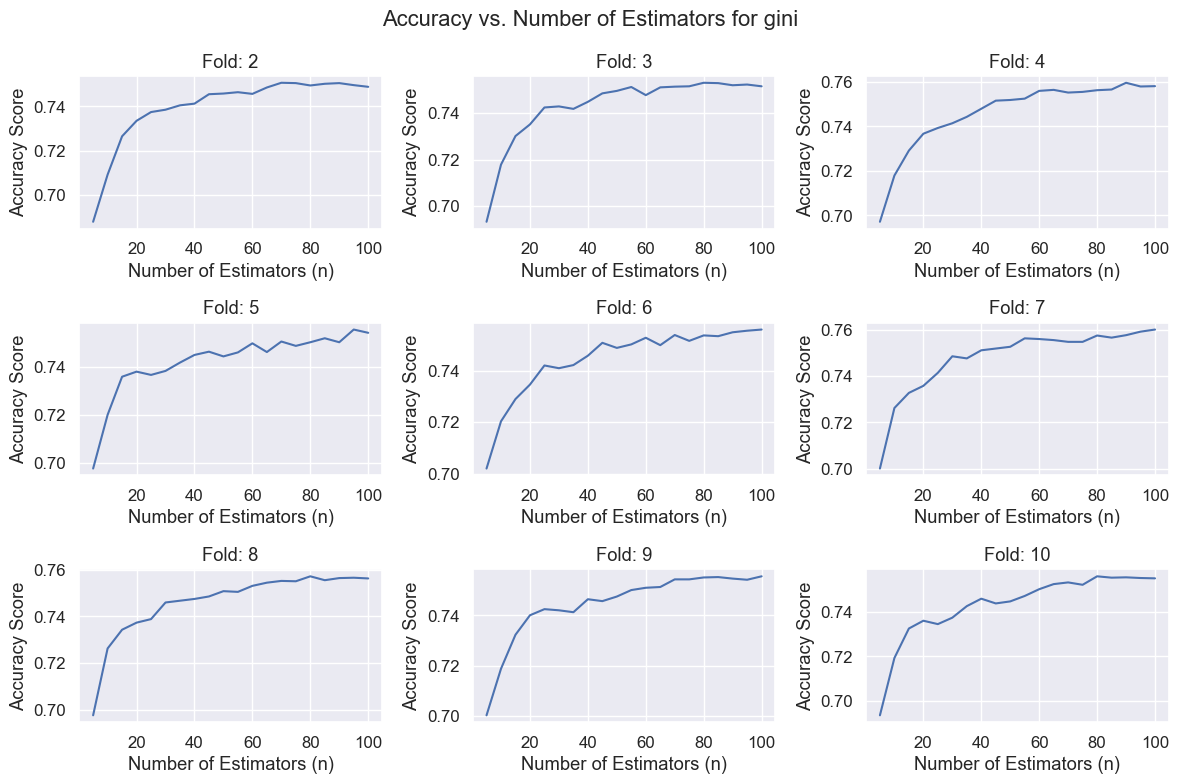

Current criterion:  entropy
Fold :  2  - Highest scoring:  0.7515551324794565  at n_val =  85
Fold :  3  - Highest scoring:  0.7577686827345763  at n_val =  45
Fold :  4  - Highest scoring:  0.7589841409853538  at n_val =  100
Fold :  5  - Highest scoring:  0.7544378202035518  at n_val =  80
Fold :  6  - Highest scoring:  0.7559519673532412  at n_val =  90
Fold :  7  - Highest scoring:  0.7585273864765391  at n_val =  85
Fold :  8  - Highest scoring:  0.7561051044424831  at n_val =  90
Fold :  9  - Highest scoring:  0.7550401697741398  at n_val =  80
Fold :  10  - Highest scoring:  0.7550457534372558  at n_val =  65


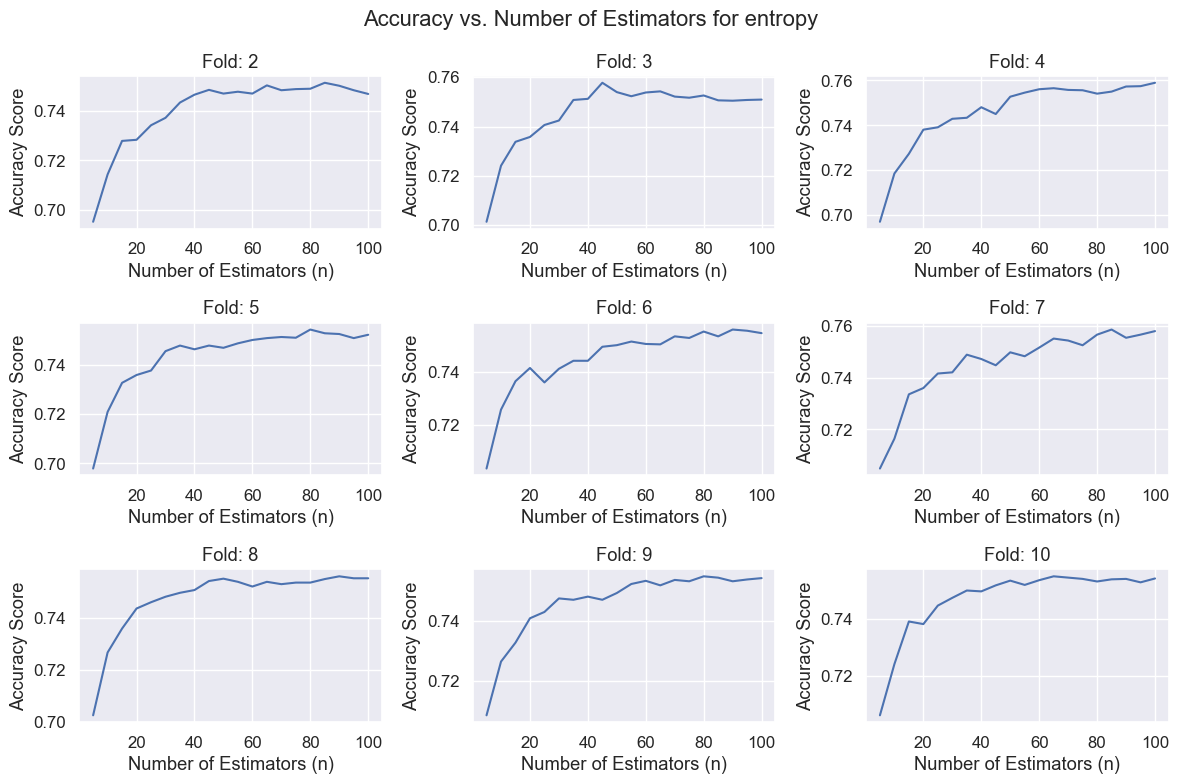

Current criterion:  log_loss
Fold :  2  - Highest scoring:  0.7515551324794565  at n_val =  85
Fold :  3  - Highest scoring:  0.7577686827345763  at n_val =  45
Fold :  4  - Highest scoring:  0.7589841409853538  at n_val =  100
Fold :  5  - Highest scoring:  0.7544378202035518  at n_val =  80
Fold :  6  - Highest scoring:  0.7559519673532412  at n_val =  90
Fold :  7  - Highest scoring:  0.7585273864765391  at n_val =  85
Fold :  8  - Highest scoring:  0.7561051044424831  at n_val =  90
Fold :  9  - Highest scoring:  0.7550401697741398  at n_val =  80
Fold :  10  - Highest scoring:  0.7550457534372558  at n_val =  65


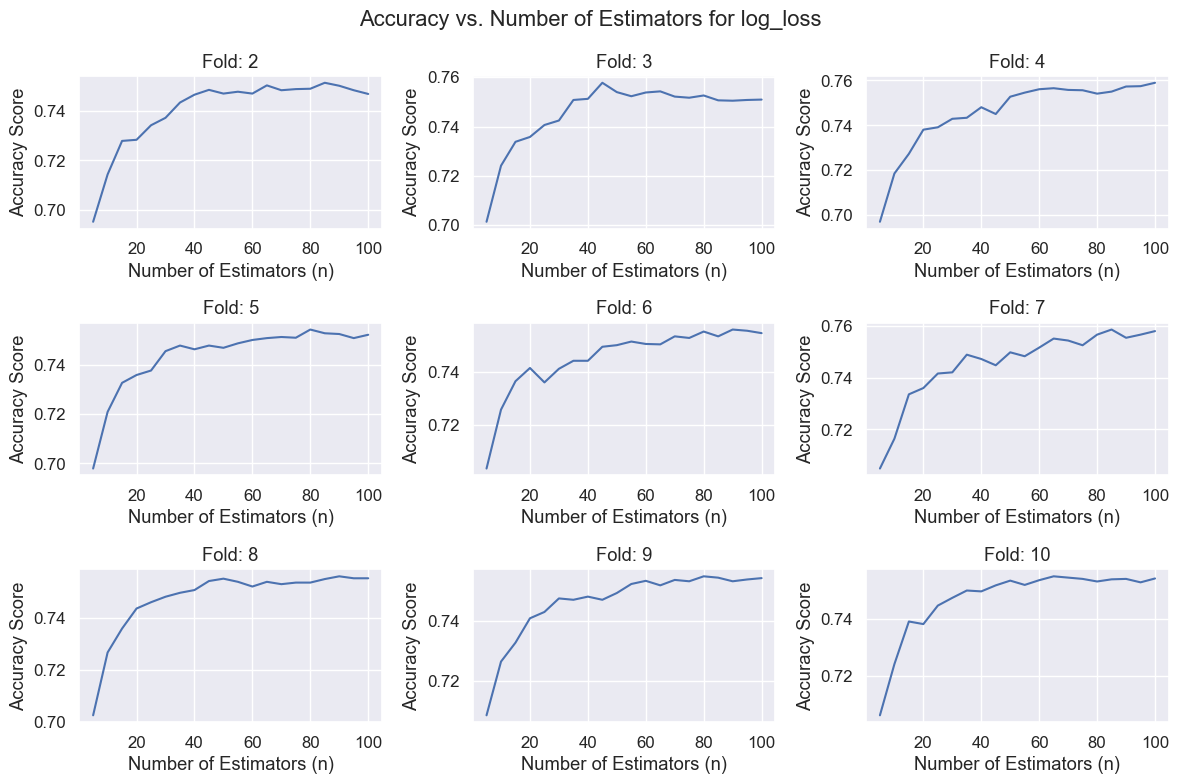

In [18]:
# get max score from all test sizes
# use ccv for more fair testing

rows = int(np.round(len(folds)/3))

all_top_scores = []
top_scores = {}

for cri, inner in scores_dict.items():
    max_score = 0
    max_size = 0
    max_nval = 0
        
    plt.figure(figsize=(12, 8))
    curr_row = 1
    
    print('Current criterion: ', cri)
    
    for i, (index, scoring) in enumerate(inner.items()):
        
        if i >= 3:
            curr_row = 2
        
        ax = plt.subplot(rows, 3, i + 1)
        ax.plot(n_vals, scoring)
        ax.set_xlabel('Number of Estimators (n)')
        ax.set_ylabel('Accuracy Score')
        ax.set_title('Fold: ' + str(index))
        
        print('Fold : ', index, ' - Highest scoring: ', np.max(scoring), ' at n_val = ', n_vals[np.argmax(scoring)])
        all_top_scores.append((str(cri), index, np.max(scoring), n_vals[np.argmax(scoring)]))
        
        # get top
        curr_max = np.max(scoring)
        if curr_max > max_score:
            max_score = curr_max
            max_size = index
            max_n_val = n_vals[np.argmax(scoring)]
        
        top_scores[cri] = {'Folds': max_size, 'Accuracy': max_score, 'n_val': max_n_val}
        
    plt.suptitle('Accuracy vs. Number of Estimators for ' + cri)
    plt.tight_layout()
    plt.show()

In [19]:
rfc_all_scores_df = pd.DataFrame(all_top_scores, columns=['Criterion', 'Fold', 'Highest Accuracy Score', 'n_val of Highest Accuracy Score'])
save = folder_path + 'RandomForestClassifier_AllAccuracyScores.csv'
rfc_all_scores_df.to_csv(save, index=False)
display(rfc_all_scores_df)

,Criterion,Fold,Highest Accuracy Score,n_val of Highest Accuracy Score
0,gini,2,0.750646,70
1,gini,3,0.753070,80
2,gini,4,0.759590,90
3,gini,5,0.755650,95
4,gini,6,0.755954,100
5,gini,7,0.760045,100
6,gini,8,0.757166,80
7,gini,9,0.755495,100
8,gini,10,0.755802,80
9,entropy,2,0.751555,85


In [20]:
rfc_top_scores = top_scores.copy()
top_scores

{'gini': {'Folds': 7, 'Accuracy': 0.7600447207542061, 'n_val': 100},
 'entropy': {'Folds': 4, 'Accuracy': 0.7589841409853538, 'n_val': 100},
 'log_loss': {'Folds': 4, 'Accuracy': 0.7589841409853538, 'n_val': 100}}

### Feature Importance and Classification Matrices of Top Scores for Each Criterion

Accuracy score for Random Forest Classifier - gini  :  0.7600424435349401


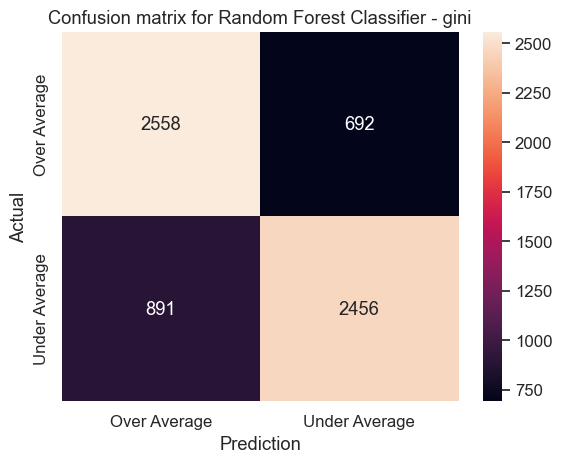

Classification report for Random Forest Classifier - gini  : 
               precision    recall  f1-score   support

 Over Average       0.74      0.79      0.76      3250
Under Average       0.78      0.73      0.76      3347

     accuracy                           0.76      6597
    macro avg       0.76      0.76      0.76      6597
 weighted avg       0.76      0.76      0.76      6597

AUC ROC score for Random Forest Classifier - gini : 0.8396325986532142
----------------------------------------------------------------------------------------------------
Accuracy score for Random Forest Classifier - entropy  :  0.758981355161437


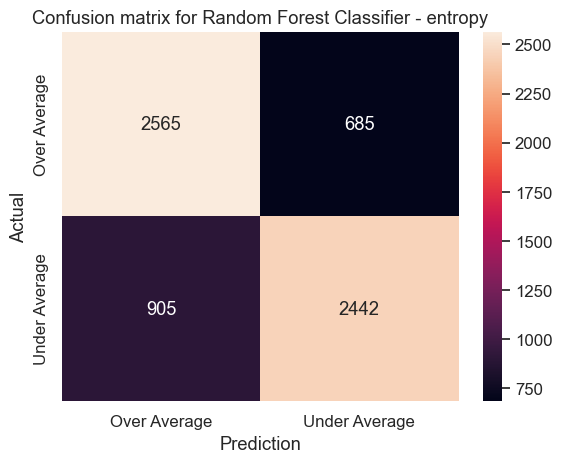

Classification report for Random Forest Classifier - entropy  : 
               precision    recall  f1-score   support

 Over Average       0.74      0.79      0.76      3250
Under Average       0.78      0.73      0.75      3347

     accuracy                           0.76      6597
    macro avg       0.76      0.76      0.76      6597
 weighted avg       0.76      0.76      0.76      6597

AUC ROC score for Random Forest Classifier - entropy : 0.836856519041162
----------------------------------------------------------------------------------------------------
Accuracy score for Random Forest Classifier - log_loss  :  0.758981355161437


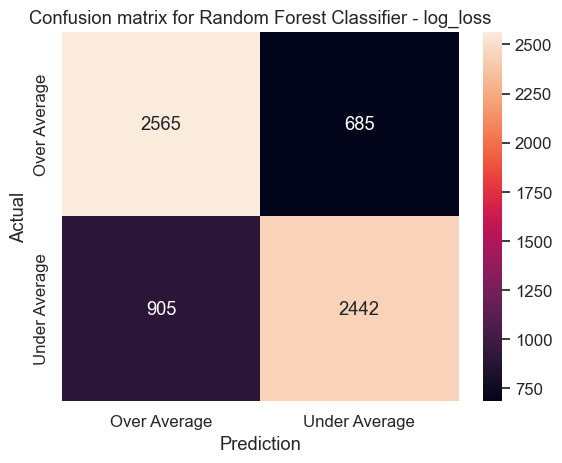

Classification report for Random Forest Classifier - log_loss  : 
               precision    recall  f1-score   support

 Over Average       0.74      0.79      0.76      3250
Under Average       0.78      0.73      0.75      3347

     accuracy                           0.76      6597
    macro avg       0.76      0.76      0.76      6597
 weighted avg       0.76      0.76      0.76      6597

AUC ROC score for Random Forest Classifier - log_loss : 0.836856519041162
----------------------------------------------------------------------------------------------------


In [21]:
#  feature_importances with top scores

feature_df_list = []
eval_scores_list = []

for cri, inner in top_scores.items():
    fold = inner['Folds']
    
    rf = RandomForestClassifier(n_estimators=inner['n_val'], criterion=cri, random_state=5)
    
    cv_res, y_pred, y_proba = crossValidate_pred(rf, fold)
    
    eval, eval_scores = getEvaluationMetrics(y_enc, y_pred, y_proba)
    showEvaluationMetrics(eval, ('Random Forest Classifier - ' + cri))
    print('-' * 100)
    eval_scores_list.append(eval_scores)
        
    features_df = get_importance(cv_res, cri)
    feature_df_list.append(features_df)    

In [39]:
eval_cols = ['Accuracy',
             'OverAverage_precision', 'OverAverage_recall', 'OverAverage_f1-score', 'OverAverage_support',
             'UnderAverage_precision', 'UnderAverage_recall', 'UnderAverage_f1-score', 'UnderAverage_support',
             'AUC_ROC_score']

In [22]:
rfc_top_scores_eval_df = pd.DataFrame(eval_scores_list, columns=eval_cols, index=criterions)
save = folder_path + 'RandomForestClassifier_TopAccuracy_Evaluation.csv'
rfc_top_scores_eval_df.to_csv(save, index=False)
display(rfc_top_scores_eval_df)

,Accuracy,OverAverage_precision,OverAverage_recall,OverAverage_f1-score,OverAverage_support,UnderAverage_precision,UnderAverage_recall,UnderAverage_f1-score,UnderAverage_support,AUC_ROC_score
gini,0.760042,0.741664,0.787077,0.763696,3250.0,0.780178,0.733791,0.756274,3347.0,0.839633
entropy,0.758981,0.739193,0.789231,0.763393,3250.0,0.780940,0.729609,0.754402,3347.0,0.836857
log_loss,0.758981,0.739193,0.789231,0.763393,3250.0,0.780940,0.729609,0.754402,3347.0,0.836857


In [23]:
rfc_importance_df = pd.DataFrame()
for i in feature_df_list:
    rfc_importance_df = pd.concat([rfc_importance_df, i], axis=1)

save = folder_path + 'RandomForestClassifier_TopAccuracy_Importance.csv'
rfc_importance_df.to_csv(save, index=False)
display(rfc_importance_df)

,Features_gini,Importance_gini,Features_entropy,Importance_entropy,Features_log_loss,Importance_log_loss
0,Current work - Requirements - Education level,0.100609,Current work - Requirements - Education level,0.087180,Current work - Requirements - Education level,0.087180
1,GENDER_R,0.038942,GENDER_R,0.032250,GENDER_R,0.032250
2,Skill use work - How often - Teaching people,0.030630,Skill use work - How often - Teaching people,0.031894,Skill use work - How often - Teaching people,0.031894
3,Skill use work - How often - Sharing work-rela...,0.028564,Skill use work - How often - Sharing work-rela...,0.029348,Skill use work - How often - Sharing work-rela...,0.029348
4,About yourself - Learning strategies - Figure ...,0.023615,About yourself - Learning strategies - Figure ...,0.022945,About yourself - Learning strategies - Figure ...,0.022945
...,...,...,...,...,...,...
73,Education - Highest qualification - Level of f...,0.002476,Education - Highest qualification - Level of f...,0.002555,Education - Highest qualification - Level of f...,0.002555
74,Skill use work - How often - Negotiating with ...,0.001569,Background - Born in country,0.001582,Background - Born in country,0.001582
75,Background - Born in country,0.001496,Skill use work - How often - Presentations,0.001416,Skill use work - How often - Presentations,0.001416
76,Skill use work - How often - Presentations,0.001307,Skill use work - How often - Negotiating with ...,0.001364,Skill use work - How often - Negotiating with ...,0.001364


## Decision Tree
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/modules/tree.html

In [17]:
from sklearn.tree import DecisionTreeClassifier

### Best Accuracy

In [34]:
criterions = ['gini', 'entropy', 'log_loss']

scores_dict = {}

for cri in criterions:
    scores_dict[cri] = {}
    
    for fold in folds:
        scores_dict[cri][fold] = None
        
        model = DecisionTreeClassifier(criterion=cri, random_state=5)
        score = crossValidate(model, fold)

        scores_dict[cri][fold] = score

Fold:  2
Scores:  [0.67202182 0.65100061] ------------------------- Mean score:  0.6615112156117654

Fold:  3
Scores:  [0.67894497 0.67530696 0.68030923] ------------------------- Mean score:  0.6781870547218434

Fold:  4
Scores:  [0.65090909 0.6531231  0.66707095 0.66828381] ------------------------- Mean score:  0.659846739070511

Fold:  5
Scores:  [0.63863636 0.66439394 0.6535254  0.65125095 0.67096285] ------------------------- Mean score:  0.6557538998782365

Fold:  6
Scores:  [0.64909091 0.66       0.67636364 0.66242038 0.68698817 0.69517743] ------------------------- Mean score:  0.6716734221192819

Fold:  7
Scores:  [0.66171792 0.68186638 0.6892895  0.66454352 0.67409766 0.68046709
 0.64968153] ------------------------- Mean score:  0.6716662308451625

Fold:  8
Scores:  [0.62666667 0.65939394 0.69818182 0.67393939 0.65454545 0.66747573
 0.68932039 0.67839806] ------------------------- Mean score:  0.6684901809355692

Fold:  9
Scores:  [0.6425648  0.66575716 0.65484311 0.6862210

In [35]:
all_scores = []
top_scores = {}

for cri, inner in scores_dict.items():
    max_size = 0
    max_score = 0
    
    print(cri)
    
    for size, acc in inner.items():

        print(size, '-', acc)
        all_scores.append((str(cri), str(size), acc))
        
        if acc > max_score:
            max_score = acc
            max_size = size
    top_scores[cri] = {'Fold': max_size, 'Accuracy': max_score}
    print()

print('Top Scores')
dt_top_scores = top_scores.copy()

print(top_scores)

gini
2 - 0.6615112156117654
3 - 0.6781870547218434
4 - 0.659846739070511
5 - 0.6557538998782365
6 - 0.6716734221192819
7 - 0.6716662308451625
8 - 0.6684901809355692
9 - 0.6687888434136728
10 - 0.6671285694578561

entropy
2 - 0.6568153497090377
3 - 0.6724268606942551
4 - 0.672124060495801
5 - 0.6624251613940773
6 - 0.6689458736592494
7 - 0.6660632709899517
8 - 0.6666725507502207
9 - 0.669849931787176
10 - 0.6678792477123281

log_loss
2 - 0.6568153497090377
3 - 0.6724268606942551
4 - 0.672124060495801
5 - 0.6624251613940773
6 - 0.6689458736592494
7 - 0.6660632709899517
8 - 0.6666725507502207
9 - 0.669849931787176
10 - 0.6678792477123281

Top Scores
{'gini': {'Fold': 3, 'Accuracy': 0.6781870547218434}, 'entropy': {'Fold': 3, 'Accuracy': 0.6724268606942551}, 'log_loss': {'Fold': 3, 'Accuracy': 0.6724268606942551}}


In [36]:
dt_all_scores_df = pd.DataFrame(all_scores, columns=['Criterion', 'Fold', 'Highest Accuracy Score'])
save = folder_path + 'DecisionTree_AllAccuracyScores.csv'

dt_all_scores_df.to_csv(save, index=False)
display(dt_all_scores_df)

,Criterion,Fold,Highest Accuracy Score
0,gini,2,0.661511
1,gini,3,0.678187
2,gini,4,0.659847
3,gini,5,0.655754
4,gini,6,0.671673
5,gini,7,0.671666
6,gini,8,0.668490
7,gini,9,0.668789
8,gini,10,0.667129
9,entropy,2,0.656815


### Feature Importance

Accuracy score for Decision Tree Classifier - gini  :  0.6781870547218433


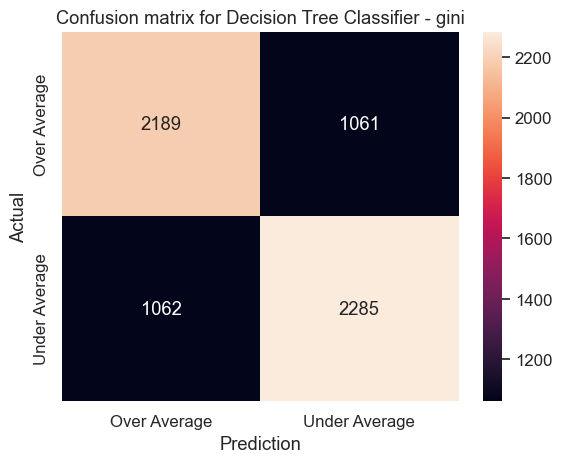

Classification report for Decision Tree Classifier - gini  : 
               precision    recall  f1-score   support

 Over Average       0.67      0.67      0.67      3250
Under Average       0.68      0.68      0.68      3347

     accuracy                           0.68      6597
    macro avg       0.68      0.68      0.68      6597
 weighted avg       0.68      0.68      0.68      6597

AUC ROC score for Decision Tree Classifier - gini : 0.6781196938705155
----------------------------------------------------------------------------------------------------
Accuracy score for Decision Tree Classifier - entropy  :  0.672426860694255


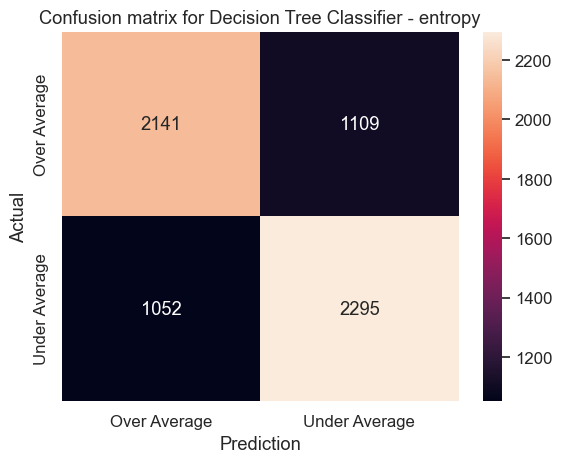

Classification report for Decision Tree Classifier - entropy  : 
               precision    recall  f1-score   support

 Over Average       0.67      0.66      0.66      3250
Under Average       0.67      0.69      0.68      3347

     accuracy                           0.67      6597
    macro avg       0.67      0.67      0.67      6597
 weighted avg       0.67      0.67      0.67      6597

AUC ROC score for Decision Tree Classifier - entropy : 0.6722289535979408
----------------------------------------------------------------------------------------------------
Accuracy score for Decision Tree Classifier - log_loss  :  0.672426860694255


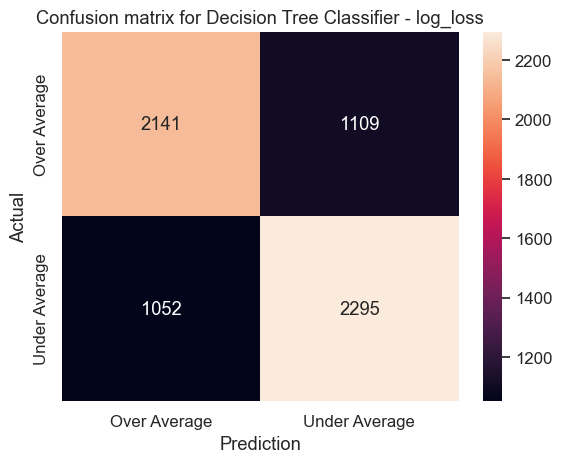

Classification report for Decision Tree Classifier - log_loss  : 
               precision    recall  f1-score   support

 Over Average       0.67      0.66      0.66      3250
Under Average       0.67      0.69      0.68      3347

     accuracy                           0.67      6597
    macro avg       0.67      0.67      0.67      6597
 weighted avg       0.67      0.67      0.67      6597

AUC ROC score for Decision Tree Classifier - log_loss : 0.6722289535979408
----------------------------------------------------------------------------------------------------


In [37]:
#  feature_importances with top scores

feature_df_list = []
eval_scores_list = []

for cri, inner in top_scores.items():
    fold = inner['Fold']
    
    model = DecisionTreeClassifier(criterion=cri, random_state=5)
    
    cv_res, y_pred, y_proba = crossValidate_pred(model, fold)
    
    eval, eval_scores = getEvaluationMetrics(y_enc, y_pred, y_proba)
    showEvaluationMetrics(eval, ('Decision Tree Classifier - ' + cri))
    print('-' * 100)
    eval_scores_list.append(eval_scores)
        
    features_df = get_importance(cv_res, cri)
    feature_df_list.append(features_df)    

In [40]:
dt_top_scores_eval_df = pd.DataFrame(eval_scores_list, columns=eval_cols, index=criterions)
save = folder_path + 'DecisionTreeClassifier_TopAccuracy_Evaluation.csv'
dt_top_scores_eval_df.to_csv(save, index=False)
display(dt_top_scores_eval_df)

,Accuracy,OverAverage_precision,OverAverage_recall,OverAverage_f1-score,OverAverage_support,UnderAverage_precision,UnderAverage_recall,UnderAverage_f1-score,UnderAverage_support,AUC_ROC_score
gini,0.678187,0.673331,0.673538,0.673435,3250.0,0.682905,0.682701,0.682803,3347.0,0.678120
entropy,0.672427,0.670529,0.658769,0.664597,3250.0,0.674207,0.685689,0.679899,3347.0,0.672229
log_loss,0.672427,0.670529,0.658769,0.664597,3250.0,0.674207,0.685689,0.679899,3347.0,0.672229


In [41]:
dt_importance_df = pd.DataFrame()
for i in feature_df_list:
    dt_importance_df = pd.concat([dt_importance_df, i], axis=1)
    
save = folder_path + 'DecisionTreeClassifier_TopAccuracy_Importance.csv'

dt_importance_df.to_csv(save, index=False)
display(dt_importance_df)

,Features_gini,Importance_gini,Features_entropy,Importance_entropy,Features_log_loss,Importance_log_loss
0,Current work - Requirements - Education level,0.189814,Current work - Requirements - Education level,0.152293,Current work - Requirements - Education level,0.152293
1,GENDER_R,0.057833,GENDER_R,0.044766,GENDER_R,0.044766
2,Skill use work - How often - Teaching people,0.035822,Skill use work - How often - Teaching people,0.039122,Skill use work - How often - Teaching people,0.039122
3,About yourself - Learning strategies - Relate ...,0.031389,About yourself - Learning strategies - Relate ...,0.031598,About yourself - Learning strategies - Relate ...,0.031598
4,Skill use work - How often - Sharing work-rela...,0.028442,Skill use work - How often - Sharing work-rela...,0.027501,Skill use work - How often - Sharing work-rela...,0.027501
...,...,...,...,...,...,...
73,LNG_HOME,0.000693,LNG_HOME,0.000841,LNG_HOME,0.000841
74,Skill use work - How often - Presentations,0.000585,Skill use work - How often - Presentations,0.000485,Skill use work - How often - Presentations,0.000485
75,Background - Born in country,0.000424,Skill use work - How often - Negotiating with ...,0.000246,Skill use work - How often - Negotiating with ...,0.000246
76,Skill use work - How often - Negotiating with ...,0.000202,Background - Born in country,0.000246,Background - Born in country,0.000246


## SVM

### Best accuracy

In [31]:
from sklearn import svm
from sklearn.inspection import permutation_importance

In [32]:
# 6-7 minute runtime
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

scores_dict = {}

for ker in kernels:
    scores_dict[ker] = {}

    for fold in folds:
        scores_dict[ker][fold] = None
        
        model = svm.SVC(kernel=ker)
        score = crossValidate(model, fold)
        
        scores_dict[ker][fold] = score

Fold:  2
Scores:  [0.7250682  0.75166768] ------------------------- Mean score:  0.738367939932916

Fold:  3
Scores:  [0.72123693 0.74533879 0.75170532] ------------------------- Mean score:  0.7394270122783083

Fold:  4
Scores:  [0.72181818 0.73256519 0.75560946 0.75924803] ------------------------- Mean score:  0.7423102155576382

Fold:  5
Scores:  [0.7280303  0.73409091 0.74829416 0.73616376 0.75890826] ------------------------- Mean score:  0.741097479725228

Fold:  6
Scores:  [0.73       0.71363636 0.74363636 0.75341219 0.74977252 0.75705187] ------------------------- Mean score:  0.741251550996774

Fold:  7
Scores:  [0.72640509 0.7242842  0.73382821 0.75690021 0.73779193 0.75690021
 0.75053079] ------------------------- Mean score:  0.7409486627999168

Fold:  8
Scores:  [0.72484848 0.72242424 0.72242424 0.74060606 0.74666667 0.75364078
 0.77063107 0.74393204] ------------------------- Mean score:  0.7406466975581053

Fold:  9
Scores:  [0.71350614 0.73806276 0.71350614 0.74897681 

In [33]:
all_scores = []
top_scores = {}

for cri, inner in scores_dict.items():
    max_size = 0
    max_score = 0
    
    print(cri)
    
    for size, acc in inner.items():

        print(size, '-', acc)
        all_scores.append((str(cri), str(size), acc))
        
        if acc > max_score:
            max_score = acc
            max_size = size
    top_scores[cri] = {'Fold': max_size, 'Accuracy': max_score}
    print()

print('Top Scores')

svm_top_scores = top_scores.copy()

print(top_scores)

linear
2 - 0.738367939932916
3 - 0.7394270122783083
4 - 0.7423102155576382
5 - 0.741097479725228
6 - 0.741251550996774
7 - 0.7409486627999168
8 - 0.7406466975581053
9 - 0.74245869334546
10 - 0.7414045615487194

poly
2 - 0.6202836609436198
3 - 0.623313627406397
4 - 0.6214969586710035
5 - 0.6251362372780114
6 - 0.6248345603441144
7 - 0.6261989513909461
8 - 0.6260455280964989
9 - 0.6272548127936941
10 - 0.6257440106681381

rbf
2 - 0.5581349788816318
3 - 0.570410792784599
4 - 0.5895141224249775
5 - 0.5983094401176281
6 - 0.6069491548790912
7 - 0.6114976145607481
8 - 0.6128616872609591
9 - 0.6134606639381537
10 - 0.6140761944176208

sigmoid
2 - 0.5137182077888608
3 - 0.5064423222676974
4 - 0.5040153812227797
5 - 0.5050748960415374
6 - 0.5114424959329417
7 - 0.5105332107243611
8 - 0.5120511547513975
9 - 0.510231923601637
10 - 0.5134156435370396

Top Scores
{'linear': {'Fold': 9, 'Accuracy': 0.74245869334546}, 'poly': {'Fold': 9, 'Accuracy': 0.6272548127936941}, 'rbf': {'Fold': 10, 'Accuracy'

In [34]:
svm_all_scores_df = pd.DataFrame(all_scores, columns=['Kernel', 'Fold', 'Highest Accuracy Score'])

save = folder_path + 'SVM_AllAccuracyScores.csv'
svm_all_scores_df.to_csv(save, index=False)
display(svm_all_scores_df)

,Kernel,Fold,Highest Accuracy Score
0,linear,2,0.738368
1,linear,3,0.739427
2,linear,4,0.742310
3,linear,5,0.741097
4,linear,6,0.741252
5,linear,7,0.740949
6,linear,8,0.740647
7,linear,9,0.742459
8,linear,10,0.741405
9,poly,2,0.620284


### Feature importance

Accuracy score for SVM - linear  :  0.7424586933454601


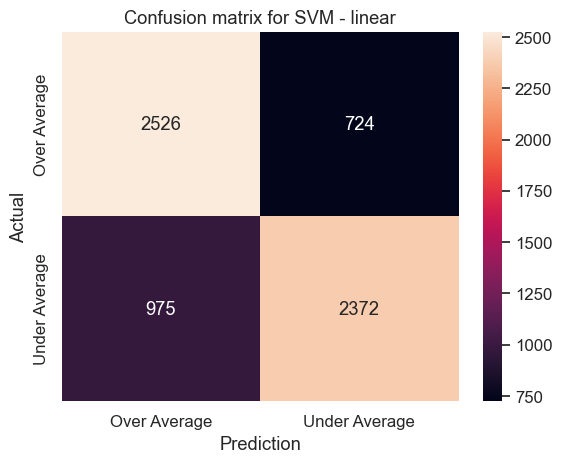

Classification report for SVM - linear  : 
               precision    recall  f1-score   support

 Over Average       0.72      0.78      0.75      3250
Under Average       0.77      0.71      0.74      3347

     accuracy                           0.74      6597
    macro avg       0.74      0.74      0.74      6597
 weighted avg       0.74      0.74      0.74      6597

AUC ROC score for SVM - linear : 0.815173450391855
----------------------------------------------------------------------------------------------------
Accuracy score for SVM - poly  :  0.6272548127936941


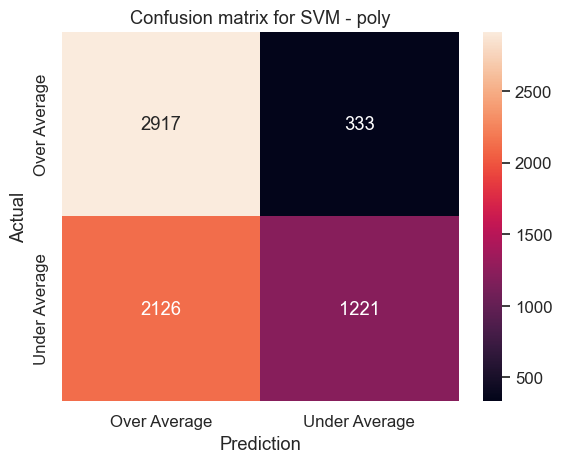

Classification report for SVM - poly  : 
               precision    recall  f1-score   support

 Over Average       0.58      0.90      0.70      3250
Under Average       0.79      0.36      0.50      3347

     accuracy                           0.63      6597
    macro avg       0.68      0.63      0.60      6597
 weighted avg       0.68      0.63      0.60      6597

AUC ROC score for SVM - poly : 0.691808875916435
----------------------------------------------------------------------------------------------------
Accuracy score for SVM - rbf  :  0.6140670001515841


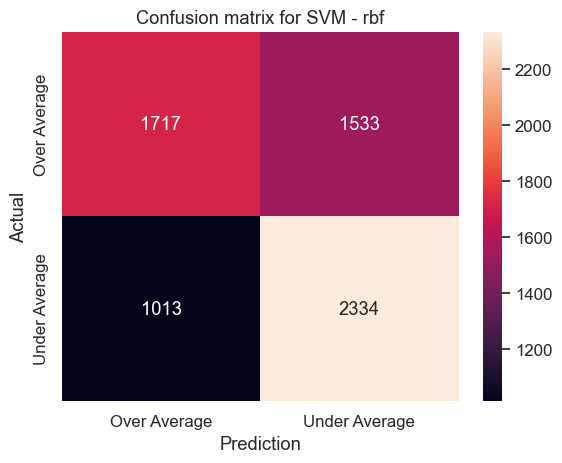

Classification report for SVM - rbf  : 
               precision    recall  f1-score   support

 Over Average       0.63      0.53      0.57      3250
Under Average       0.60      0.70      0.65      3347

     accuracy                           0.61      6597
    macro avg       0.62      0.61      0.61      6597
 weighted avg       0.62      0.61      0.61      6597

AUC ROC score for SVM - rbf : 0.6918443152306313
----------------------------------------------------------------------------------------------------
Accuracy score for SVM - sigmoid  :  0.5137183568288616


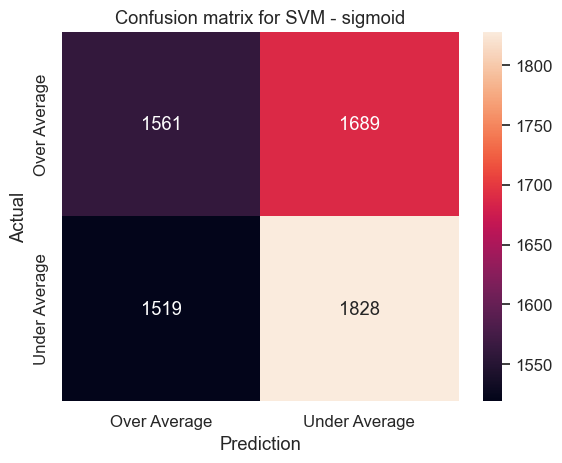

Classification report for SVM - sigmoid  : 
               precision    recall  f1-score   support

 Over Average       0.51      0.48      0.49      3250
Under Average       0.52      0.55      0.53      3347

     accuracy                           0.51      6597
    macro avg       0.51      0.51      0.51      6597
 weighted avg       0.51      0.51      0.51      6597

AUC ROC score for SVM - sigmoid : 0.5069101606490313
----------------------------------------------------------------------------------------------------


In [35]:
#  feature_importances with top scores
# linear is model.coef_
# others use permutation_importance
# 280+ runtime

feature_df_list = []
eval_scores_list = []

for ker, inner in top_scores.items():
    fold = inner['Fold']
    
    model = svm.SVC(kernel=ker, probability=True)
    cv_res, y_pred, y_proba = crossValidate_pred(model, fold)
    
    eval, eval_scores = getEvaluationMetrics(y_enc, y_pred, y_proba)
    showEvaluationMetrics(eval, ('SVM - ' + ker))
    print('-' * 100)
    eval_scores_list.append(eval_scores)
    
    # feature importances
    mean_list = []
    
    if ker == 'linear':
        for estimator in cv_res['estimator']:
            estimator.fit(X_enc, y_enc)
            imp = estimator.coef_.flatten()
            mean_list.append(imp)
    else:
        for estimator in cv_res['estimator']:
            estimator.fit(X_enc, y_enc)
            mean = permutation_importance(estimator, X_enc, y_enc, random_state=5).importances_mean
            mean_list.append(mean)
    
    importances = np.mean(mean_list, axis=0)
    
    col_ker = 'Features_' + str(ker)
    col_imp = 'Importance_' + str(ker)
    
    features_df = pd.DataFrame({col_ker: feature_names, col_imp: importances}).sort_values(col_imp, ascending=False).reset_index(drop=True)
    feature_df_list.append(features_df)

In [45]:
svm_top_scores_eval_df = pd.DataFrame(eval_scores_list, columns=eval_cols, index=kernels)

save = folder_path + 'SVM_TopAccuracy_Evaluation.csv'
svm_top_scores_eval_df.to_csv(save, index=False)
display(svm_top_scores_eval_df)

,Accuracy,OverAverage_precision,OverAverage_recall,OverAverage_f1-score,OverAverage_support,UnderAverage_precision,UnderAverage_recall,UnderAverage_f1-score,UnderAverage_support,AUC_ROC_score
linear,0.742459,0.721508,0.777231,0.748334,3250.0,0.766150,0.708694,0.736303,3347.0,0.815173
poly,0.627255,0.578426,0.897538,0.703485,3250.0,0.785714,0.364804,0.498266,3347.0,0.691809
rbf,0.614067,0.628938,0.528308,0.574247,3250.0,0.603569,0.697341,0.647075,3347.0,0.691844
sigmoid,0.513718,0.506818,0.480308,0.493207,3250.0,0.519761,0.546161,0.532634,3347.0,0.506910


In [46]:
svm_importance_df = pd.DataFrame()
for i in feature_df_list:
    svm_importance_df = pd.concat([svm_importance_df, i], axis=1)
    
save = folder_path + 'SVM_TopAccuracy_Importance.csv'

svm_importance_df.to_csv(save, index=False)
display(svm_importance_df)

,Features_linear,Importance_linear,Features_poly,Importance_poly,Features_rbf,Importance_rbf,Features_sigmoid,Importance_sigmoid
0,NATIVESPEAKER,0.395082,Current status/work history - Subjective status,0.089131,Current status/work history - Subjective status,0.029680,NFEHRS,0.013370
1,Current status/work history - Subjective status,0.394827,NFEHRSNJR,0.043201,NFEHRS,0.006609,NFEHRSJR,0.013188
2,CNTRYID,0.179803,NFEHRSJR,0.028346,NFEHRSNJR,0.006245,NFEHRSNJR,0.006761
3,Skill use work - ICT - Computer - Level of com...,0.175608,NFEHRS,0.013097,Education - Highest qualification - Area of study,0.005730,Current work - Managing other employees - Count,0.000303
4,Skill use work - How often - Working physicall...,0.125859,Skill use work - How often - Working physicall...,0.005427,Skill use work - How often - Working physicall...,0.003456,ICTWORK,0.000121
...,...,...,...,...,...,...,...,...
73,Current work - Employee or self-employed,-0.322103,Current work - Requirements - Education level,-0.001061,Skill use work - How often - Teaching people,-0.001213,About yourself - Learning strategies - Get to ...,-0.000030
74,Current work - Managing other employees,-0.416332,ICTWORK,-0.001091,Skill use work - ICT - Computer - How often - ...,-0.001243,Current work - Employees working for you - Count,-0.000061
75,Current work - Employees working for you,-0.444903,Skill use work - How often - Advising people,-0.001122,ICTWORK,-0.001576,Skill use work - How often - Selling,-0.000061
76,Background - Born in country,-0.640809,Skill use work - How often - Planning own acti...,-0.001546,Current work - Managing other employees - Count,-0.001637,Skill use work - ICT - Internet - How often - ...,-0.000061


# Comparision

## Top accuracy

In [4]:
folder_path = 'RQ1_CVV/'

In [5]:
rfc_top_scores_eval = pd.read_csv(folder_path + 'RandomForestClassifier_TopAccuracy_Evaluation.csv')
svm_top_scores_eval = pd.read_csv(folder_path + 'SVM_TopAccuracy_Evaluation.csv')
dt_top_scores_eval = pd.read_csv(folder_path + 'DecisionTreeClassifier_TopAccuracy_Evaluation.csv')

In [6]:
display('Random Forest Classifier')
display(rfc_top_scores_eval)

display('Decision Tree Classifier')
display(dt_top_scores_eval)

display('SVM')
display(svm_top_scores_eval)

'Random Forest Classifier'

,Accuracy,OverAverage_precision,OverAverage_recall,OverAverage_f1-score,OverAverage_support,UnderAverage_precision,UnderAverage_recall,UnderAverage_f1-score,UnderAverage_support,AUC_ROC_score
0,0.760042,0.741664,0.787077,0.763696,3250.0,0.780178,0.733791,0.756274,3347.0,0.839633
1,0.758981,0.739193,0.789231,0.763393,3250.0,0.780940,0.729609,0.754402,3347.0,0.836857
2,0.758981,0.739193,0.789231,0.763393,3250.0,0.780940,0.729609,0.754402,3347.0,0.836857


'Decision Tree Classifier'

,Accuracy,OverAverage_precision,OverAverage_recall,OverAverage_f1-score,OverAverage_support,UnderAverage_precision,UnderAverage_recall,UnderAverage_f1-score,UnderAverage_support,AUC_ROC_score
0,0.678187,0.673331,0.673538,0.673435,3250.0,0.682905,0.682701,0.682803,3347.0,0.678120
1,0.672427,0.670529,0.658769,0.664597,3250.0,0.674207,0.685689,0.679899,3347.0,0.672229
2,0.672427,0.670529,0.658769,0.664597,3250.0,0.674207,0.685689,0.679899,3347.0,0.672229


'SVM'

,Accuracy,OverAverage_precision,OverAverage_recall,OverAverage_f1-score,OverAverage_support,UnderAverage_precision,UnderAverage_recall,UnderAverage_f1-score,UnderAverage_support,AUC_ROC_score
0,0.742459,0.721508,0.777231,0.748334,3250.0,0.766150,0.708694,0.736303,3347.0,0.815173
1,0.627255,0.578426,0.897538,0.703485,3250.0,0.785714,0.364804,0.498266,3347.0,0.691809
2,0.614067,0.628938,0.528308,0.574247,3250.0,0.603569,0.697341,0.647075,3347.0,0.691844
3,0.513718,0.506818,0.480308,0.493207,3250.0,0.519761,0.546161,0.532634,3347.0,0.506910


In [7]:
top_eval = rfc_top_scores_eval[:1]
top_eval = pd.concat([top_eval, dt_top_scores_eval[:1]])
top_eval = pd.concat([top_eval, svm_top_scores_eval[:1]])
top_eval['Model'] = ['RandomForestClassifier_Gini', 'DecisionTreeClassifier_Gini', 'SVM_Linear']

top_eval.set_index('Model', inplace=True)
top_eval

,Accuracy,OverAverage_precision,OverAverage_recall,OverAverage_f1-score,OverAverage_support,UnderAverage_precision,UnderAverage_recall,UnderAverage_f1-score,UnderAverage_support,AUC_ROC_score
Model,,,,,,,,,,
RandomForestClassifier_Gini,0.760042,0.741664,0.787077,0.763696,3250.0,0.780178,0.733791,0.756274,3347.0,0.839633
DecisionTreeClassifier_Gini,0.678187,0.673331,0.673538,0.673435,3250.0,0.682905,0.682701,0.682803,3347.0,0.678120
SVM_Linear,0.742459,0.721508,0.777231,0.748334,3250.0,0.766150,0.708694,0.736303,3347.0,0.815173


In [46]:
save = folder_path + 'all_TopAccuracy_Evaluation.csv'

top_eval.to_csv(save)

## Features

In [50]:
rfc_importance = pd.read_csv(folder_path + 'RandomForestClassifier_TopAccuracy_Importance.csv')
dt_importance = pd.read_csv(folder_path + 'DecisionTreeClassifier_TopAccuracy_Importance.csv')
svm_importance = pd.read_csv(folder_path + 'SVM_TopAccuracy_Importance.csv')

In [51]:
display(rfc_importance)
display(dt_importance)
display(svm_importance)

,Features_gini,Importance_gini,Features_entropy,Importance_entropy,Features_log_loss,Importance_log_loss
0,Current work - Requirements - Education level,0.100609,Current work - Requirements - Education level,0.087180,Current work - Requirements - Education level,0.087180
1,GENDER_R,0.038942,GENDER_R,0.032250,GENDER_R,0.032250
2,Skill use work - How often - Teaching people,0.030630,Skill use work - How often - Teaching people,0.031894,Skill use work - How often - Teaching people,0.031894
3,Skill use work - How often - Sharing work-rela...,0.028564,Skill use work - How often - Sharing work-rela...,0.029348,Skill use work - How often - Sharing work-rela...,0.029348
4,About yourself - Learning strategies - Figure ...,0.023615,About yourself - Learning strategies - Figure ...,0.022945,About yourself - Learning strategies - Figure ...,0.022945
...,...,...,...,...,...,...
73,Education - Highest qualification - Level of f...,0.002476,Education - Highest qualification - Level of f...,0.002555,Education - Highest qualification - Level of f...,0.002555
74,Skill use work - How often - Negotiating with ...,0.001569,Background - Born in country,0.001582,Background - Born in country,0.001582
75,Background - Born in country,0.001496,Skill use work - How often - Presentations,0.001416,Skill use work - How often - Presentations,0.001416
76,Skill use work - How often - Presentations,0.001307,Skill use work - How often - Negotiating with ...,0.001364,Skill use work - How often - Negotiating with ...,0.001364


,Features_gini,Importance_gini,Features_entropy,Importance_entropy,Features_log_loss,Importance_log_loss
0,Current work - Requirements - Education level,0.189814,Current work - Requirements - Education level,0.152293,Current work - Requirements - Education level,0.152293
1,GENDER_R,0.057833,GENDER_R,0.044766,GENDER_R,0.044766
2,Skill use work - How often - Teaching people,0.035822,Skill use work - How often - Teaching people,0.039122,Skill use work - How often - Teaching people,0.039122
3,About yourself - Learning strategies - Relate ...,0.031389,About yourself - Learning strategies - Relate ...,0.031598,About yourself - Learning strategies - Relate ...,0.031598
4,Skill use work - How often - Sharing work-rela...,0.028442,Skill use work - How often - Sharing work-rela...,0.027501,Skill use work - How often - Sharing work-rela...,0.027501
...,...,...,...,...,...,...
73,LNG_HOME,0.000693,LNG_HOME,0.000841,LNG_HOME,0.000841
74,Skill use work - How often - Presentations,0.000585,Skill use work - How often - Presentations,0.000485,Skill use work - How often - Presentations,0.000485
75,Background - Born in country,0.000424,Skill use work - How often - Negotiating with ...,0.000246,Skill use work - How often - Negotiating with ...,0.000246
76,Skill use work - How often - Negotiating with ...,0.000202,Background - Born in country,0.000246,Background - Born in country,0.000246


,Features_linear,Importance_linear,Features_poly,Importance_poly,Features_rbf,Importance_rbf,Features_sigmoid,Importance_sigmoid
0,NATIVESPEAKER,0.395082,Current status/work history - Subjective status,0.089131,Current status/work history - Subjective status,0.029680,NFEHRS,0.013370
1,Current status/work history - Subjective status,0.394827,NFEHRSNJR,0.043201,NFEHRS,0.006609,NFEHRSJR,0.013188
2,CNTRYID,0.179803,NFEHRSJR,0.028346,NFEHRSNJR,0.006245,NFEHRSNJR,0.006761
3,Skill use work - ICT - Computer - Level of com...,0.175608,NFEHRS,0.013097,Education - Highest qualification - Area of study,0.005730,Current work - Managing other employees - Count,0.000303
4,Skill use work - How often - Working physicall...,0.125859,Skill use work - How often - Working physicall...,0.005427,Skill use work - How often - Working physicall...,0.003456,ICTWORK,0.000121
...,...,...,...,...,...,...,...,...
73,Current work - Employee or self-employed,-0.322103,Current work - Requirements - Education level,-0.001061,Skill use work - How often - Teaching people,-0.001213,About yourself - Learning strategies - Get to ...,-0.000030
74,Current work - Managing other employees,-0.416332,ICTWORK,-0.001091,Skill use work - ICT - Computer - How often - ...,-0.001243,Current work - Employees working for you - Count,-0.000061
75,Current work - Employees working for you,-0.444903,Skill use work - How often - Advising people,-0.001122,ICTWORK,-0.001576,Skill use work - How often - Selling,-0.000061
76,Background - Born in country,-0.640809,Skill use work - How often - Planning own acti...,-0.001546,Current work - Managing other employees - Count,-0.001637,Skill use work - ICT - Internet - How often - ...,-0.000061


In [52]:
compare = rfc_importance.iloc[:,:2].add_suffix('_RandomForestClassifier')

dt_compare = dt_importance.iloc[:,:2].add_suffix('_DecisionTreeClassifier')
compare = pd.concat([compare, dt_compare] , axis=1)

svm_compare = svm_importance.iloc[:, :2].add_suffix('_SVM')
compare = pd.concat([compare, svm_compare], axis=1)

In [53]:
save = folder_path + 'all_TopAccuracy_Importance.csv'

compare.to_csv(save, index=False)

In [55]:
display('Top 10')
display(compare.head(10))

display('Bottom 10')
display(compare.tail(10))

'Top 10'

,Features_gini_RandomForestClassifier,Importance_gini_RandomForestClassifier,Features_gini_DecisionTreeClassifier,Importance_gini_DecisionTreeClassifier,Features_linear_SVM,Importance_linear_SVM
0,Current work - Requirements - Education level,0.100609,Current work - Requirements - Education level,0.189814,NATIVESPEAKER,0.395082
1,GENDER_R,0.038942,GENDER_R,0.057833,Current status/work history - Subjective status,0.394827
2,Skill use work - How often - Teaching people,0.030630,Skill use work - How often - Teaching people,0.035822,CNTRYID,0.179803
3,Skill use work - How often - Sharing work-rela...,0.028564,About yourself - Learning strategies - Relate ...,0.031389,Skill use work - ICT - Computer - Level of com...,0.175608
4,About yourself - Learning strategies - Figure ...,0.023615,Skill use work - How often - Sharing work-rela...,0.028442,Skill use work - How often - Working physicall...,0.125859
5,About yourself - Learning strategies - Relate ...,0.022703,Education - Formal qualification - Reason job ...,0.020287,LNG_HOME,0.111720
6,Skill use work - How often - Influencing people,0.020023,Skill use everyday life - ICT - Computer - How...,0.019313,ISCOSKIL4,0.104222
7,Education - Formal qualification - Reason job ...,0.019904,NFEHRS,0.018865,Skill use work - ICT - Computer - Lack of skil...,0.101930
8,Current work - Employees working for you,0.018516,Skill use work - How often - Working physicall...,0.017370,Skill use work - ICT - Computer - Got the skil...,0.091836
9,Skill use work - Problem solving - Simple prob...,0.018427,About yourself - Learning strategies - Figure ...,0.017269,Skill use everyday life - ICT - Ever used comp...,0.091149


'Bottom 10'

,Features_gini_RandomForestClassifier,Importance_gini_RandomForestClassifier,Features_gini_DecisionTreeClassifier,Importance_gini_DecisionTreeClassifier,Features_linear_SVM,Importance_linear_SVM
68,Skill use everyday life - ICT - Internet - How...,0.005106,Skill use everyday life - ICT - Internet - How...,0.003255,Current status/work history - Current - Paid j...,-0.120051
69,Skill use work - ICT - Computer - Lack of skil...,0.004274,Skill use work - ICT - Internet - How often - ...,0.002824,Skill use everyday life - ICT - Experience wit...,-0.139691
70,ICTHOME,0.003932,Skill use work - ICT - Internet - How often - ...,0.002796,ICTWORK,-0.154071
71,CNTRYID,0.003374,CNTRYID,0.002285,NATIVELANG,-0.157531
72,LNG_HOME,0.002793,Education - Highest qualification - Level of f...,0.000793,VET,-0.188797
73,Education - Highest qualification - Level of f...,0.002476,LNG_HOME,0.000693,Current work - Employee or self-employed,-0.322103
74,Skill use work - How often - Negotiating with ...,0.001569,Skill use work - How often - Presentations,0.000585,Current work - Managing other employees,-0.416332
75,Background - Born in country,0.001496,Background - Born in country,0.000424,Current work - Employees working for you,-0.444903
76,Skill use work - How often - Presentations,0.001307,Skill use work - How often - Negotiating with ...,0.000202,Background - Born in country,-0.640809
77,ICTWORK,0.000061,ICTWORK,0.000000,GENDER_R,-0.887238


# END